In [1]:
using PauliPropagation
using Plots
using LinearAlgebra
using LaTeXStrings

In [29]:
function commutator2(A::Matrix, B::Matrix)
    return A * B - B * A
end

commutator2 (generic function with 1 method)

In [2]:
function XMatrix(n::Int, i::Int)
    Xmat = [0 1; 1 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Xmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Xmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function YMatrix(n::Int, i::Int)
    Ymat = [0 -im; im 0]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Ymat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Ymat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function ZMatrix(n::Int, i::Int)
    Zmat = [1 0; 0 -1]
    Imat = [1 0; 0 1]

    operator = (i == 1) ? Zmat : Imat

    for j in 2:n
        if j == i
            operator = kron(operator, Zmat)
        else
            operator = kron(operator, Imat)
        end
    end
    
    return operator
end

function imaginaryTimeEvolution(nqubits::Int, h::Matrix, beta::Float64)
    operator = exp(-beta*h)
    return operator/tr(exp(-beta*h))
end

function imaginaryTimeEvolutionState(nqubits::Int, h::Matrix, beta::Float64, state::Vector)
    operator = exp(-beta*h)*state
    return operator/LinearAlgebra.norm(operator)
end

imaginaryTimeEvolutionState (generic function with 1 method)

In [59]:
function comparison(P::Matrix, Q::Matrix, beta::Float64)
    num = exp(-beta/2*P)*Q*exp(-beta/2*P)
    C = commutator2(P, Q)
    if (LinearAlgebra.norm(C) < 1e-3)
        analytic = cosh(beta)*Q-sinh(beta)*P*Q
    else
        analytic = Q
    end 
    println("Numerical: ", num)
    println("Analytic: ", analytic)
    println(LinearAlgebra.norm(num-analytic))
end

comparison (generic function with 1 method)

In [24]:
function interpretPauli(p::String)
    I = [1 0; 0 1]
    X = [0 1; 1 0]
    Y = [0 -1im; 1im 0]
    Z = [1 0; 0 -1]

    if p[1] == 'I'
        mat = I
    elseif p[1] == 'X'
        mat = X
    elseif p[1] == 'Y'
        mat = Y
    elseif p[1] == 'Z'
        mat = Z
    end

    for i in 2:length(p)
        if p[i] == 'I'
            mat = kron(mat, I)
        elseif p[i] == 'X'
            mat = kron(mat, X)
        elseif p[i] == 'Y'
            mat = kron(mat, Y)
        elseif p[i] == 'Z'
            mat = kron(mat, Z)
        end
    end
    return mat
end

function generatePauliBasis(nqubits::Int)
    basis = Vector{String}(undef, 4^nqubits)
    for i in 1:4^nqubits
        basis[i] = join(rand(['I', 'X', 'Y', 'Z'], nqubits))
    end
    return basis
end

function computeTwoNorm(pstr::Vector, rho::Matrix, nq::Int)
    A = 0
    B = 1
    mix = 0
    for i in 1:size(pstr)[1]
        A += abs(pstr[i].coeff)^2
        string = (inttostring(pstr[i].term,nq))
        mix += pstr[i].coeff*tr(rho*interpretPauli(string))
    end
    A *= 2^nq
    return A+B-2*mix
end

computeTwoNorm (generic function with 1 method)

In [67]:
p = "X"
q = "X"
P = interpretPauli(p)
Q = interpretPauli(q)

comparison(P, Q, -10.0)


Numerical: [11013.232874703388 11013.232920103317; 11013.232920103317 11013.232874703388]
Analytic: [11013.232874703393 11013.232920103324; 11013.232920103324 11013.232874703393]
1.2862197421537486e-11


In [68]:
nq = 6
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

densityExponential = imaginaryTimeEvolution(6, H, -50.0);

In [5]:
θ = 0.10im

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);

nq = 6
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


In [6]:
nls = 50
nq = 6
pstr = PauliString(nq, :I, 1)
psum = PauliSum(pstr)
beta = Float64[]
overlapsEvery = Float64[]
psumEvery = psum
for i in 1:nls
    psum = propagate!(circuit, psum)
    psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
    #push!(overlapsEvery, overlapbyorthogonality(psumEvery, I))
    push!(beta, 0.1*i)
end


In [7]:
pstr = topaulistrings(psumEvery)
a = computeTwoNorm(pstr, densityExponential, 6)   


0.01841908483901289 - 0.0im

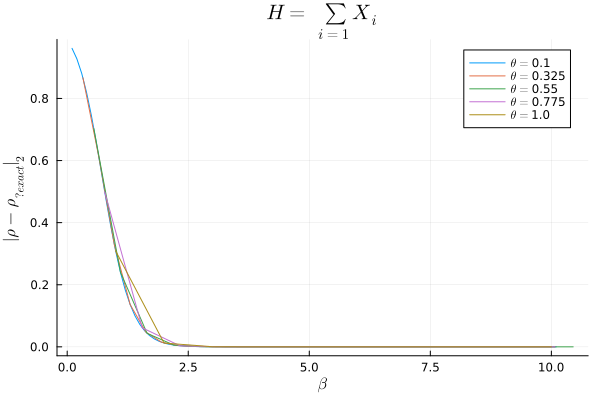

In [8]:
θ = LinRange(0.1, 1.0, 5) * 1im

nq = 6
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        #H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

densityExponential = imaginaryTimeEvolution(6, H, -50.0);
plot(xlabel = L"\beta", ylabel = L"\| \rho - \rho_{\text{exact}} \|_2", title = L"$H = \sum_{i=1} X_i$", legend = :topright)


for i in 1:size(θ)[1]
    # the computational basis matrices
    rzmat = tomatrix(PauliRotation(:Z, 1), θ[i])
    rxmat = tomatrix(PauliRotation(:X, 1), θ[i])
    rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ[i])


    # the Pauli basis matrices
    rzptm = calculateptm(rzmat; heisenberg=false)
    rxptm = calculateptm(rxmat; heisenberg=false)
    rzzptm = calculateptm(rzzmat; heisenberg=false)

    # the Pauli basis transfermaps
    rzmap = totransfermap(rzptm)
    rxmap = totransfermap(rxptm)
    rzzmap = totransfermap(rzzptm);


    nq = 6
    topology = bricklayertopology(nq)

    # the circuit
    circuit = Gate[]
    append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
    #append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)
    beta = Float64[]
    distance = Float64[]
    psumEvery = psum
    totalAngle = 0
    while totalAngle < 10
        psum = propagate!(circuit, psum)
        psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
        pstr = topaulistrings(psumEvery)
        push!(distance, computeTwoNorm(pstr, densityExponential, 6))
        totalAngle += imag(θ[i])
        push!(beta, totalAngle)
    end
    plot!(beta, distance, label = L"\theta = "*string(imag(θ[i])))
end
display(plot!())

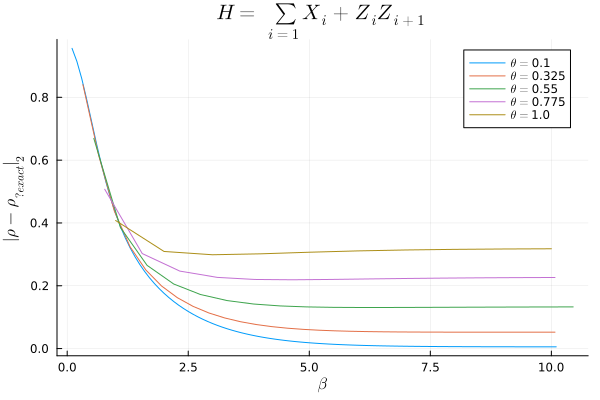

In [9]:
θ = LinRange(0.1, 1.0, 5) * 1im

nq = 6
H = I(2^nq)
for i in 1:nq
    H += XMatrix(nq, i)
    if i < nq
        H -= ZMatrix(nq, i)*ZMatrix(nq, i+1)
    end
end

densityExponential = imaginaryTimeEvolution(6, H, -50.0);
plot(xlabel = L"\beta", ylabel = L"\| \rho - \rho_{\text{exact}} \|_2", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$", legend = :topright)


for i in 1:size(θ)[1]
    # the computational basis matrices
    rzmat = tomatrix(PauliRotation(:Z, 1), θ[i])
    rxmat = tomatrix(PauliRotation(:X, 1), θ[i])
    rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ[i])


    # the Pauli basis matrices
    rzptm = calculateptm(rzmat; heisenberg=false)
    rxptm = calculateptm(rxmat; heisenberg=false)
    rzzptm = calculateptm(rzzmat; heisenberg=false)

    # the Pauli basis transfermaps
    rzmap = totransfermap(rzptm)
    rxmap = totransfermap(rxptm)
    rzzmap = totransfermap(rzzptm);


    nq = 6
    topology = bricklayertopology(nq)

    # the circuit
    circuit = Gate[]
    append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
    append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


    pstr = PauliString(nq, :I, 1)
    psum = PauliSum(pstr)
    beta = Float64[]
    distance = Float64[]
    psumEvery = psum
    totalAngle = 0
    while totalAngle < 10
        psum = propagate!(circuit, psum)
        psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
        pstr = topaulistrings(psumEvery)
        push!(distance, computeTwoNorm(pstr, densityExponential, 6))
        totalAngle += imag(θ[i])
        push!(beta, totalAngle)
    end
    plot!(beta, distance, label = L"\theta = "*string(imag(θ[i])))
end
display(plot!())

In [10]:
θ = 0.10im

# the computational basis matrices
rzmat = tomatrix(PauliRotation(:Z, 1), θ)
rxmat = tomatrix(PauliRotation(:X, 1), θ)
rzzmat = tomatrix(PauliRotation([:Z, :Z], [1, 2]), -θ)

# the Pauli basis matrices
rzptm = calculateptm(rzmat; heisenberg=false)
rxptm = calculateptm(rxmat; heisenberg=false)
rzzptm = calculateptm(rzzmat; heisenberg=false)

# the Pauli basis transfermaps
rzmap = totransfermap(rzptm)
rxmap = totransfermap(rxptm)
rzzmap = totransfermap(rzzptm);

nq = 6
topology = bricklayertopology(nq)

# the circuit
circuit = Gate[]
append!(circuit, TransferMapGate(rxmap, ii) for ii in 1:nq);
#append!(circuit, TransferMapGate(rzmap, ii) for ii in 1:nq);
append!(circuit, TransferMapGate(rzzmap,collect(pair)) for pair in topology);


In [19]:
minCoeff = 10 .^ LinRange(-3, -1.7, 20)
distance = Float64[]
nls = 100
nq = 6
pstr = PauliString(nq, :I, 1)
for i in minCoeff
    distanceLoop = Float64[]
    psum = PauliSum(pstr)
    for j in 1:nls
        psum = propagate!(circuit, psum; min_abs_coeff=i)
        psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
        pstr = topaulistrings(psumEvery)
        push!(distanceLoop, computeTwoNorm(pstr, densityExponential, 6))
    end
    push!(distance, distanceLoop[end])
end

plot(minCoeff, distance, ylabel=L"Distance", xlabel="Coefficient truncation", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$",xscale=:log10, yscale=:log10)



BoundsError: BoundsError: attempt to access 0-element Vector{PauliString{UInt16, Float64}} at index [1]

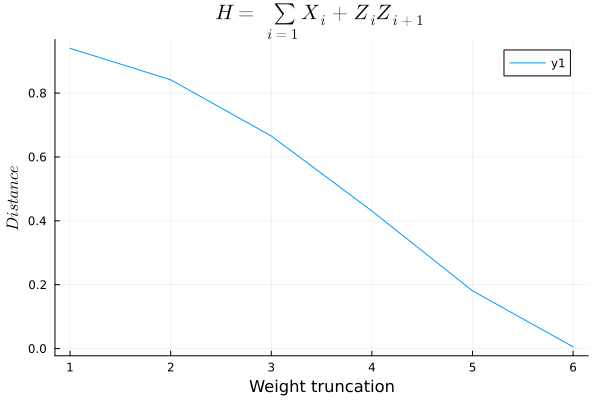

In [14]:
weightCoeff = (1:1:6)
distance = Float64[]
nls = 100
nq = 6
pstr = PauliString(nq, :I, 1)
for i in weightCoeff
    distanceLoop = Float64[]
    psum = PauliSum(pstr)
    for j in 1:nls
        psum = propagate!(circuit, psum; max_weight=i)
        psumEvery = psum/(2^nq*getcoeff(psum, :I, 1))
        pstr = topaulistrings(psumEvery)
        push!(distanceLoop, computeTwoNorm(pstr, densityExponential, 6))
    end
    push!(distance, distanceLoop[end])
end

plot(weightCoeff, distance, ylabel=L"Distance", xlabel="Weight truncation", title = L"$H = \sum_{i=1} X_i + Z_iZ_{i+1}$")

